# Test trained model(s)

In [1]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher Chan        #
#Version: 0.3.3                      #
#Date: 2022-04-26                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
from scipy import ndimage
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

print(f"Training on device {device}.")

data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")
Four_UNet = Four_UNet()

Training on device cpu.


In [2]:
TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 136 and labels pair: 136 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_28215-22059.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_28215-22059.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_8037-16416.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_8037-16416.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_29241-22914.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_29241-22914.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_29925-23256.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_29925-23256.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_7524-17271.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KBY15_LBL_7524-17271.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/IMG/KBY15_IMG_28728-11457.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/Test_15cm/LBL/KB

<class 'torch.Tensor'>


Text(0.5, 1.0, 'LBL')

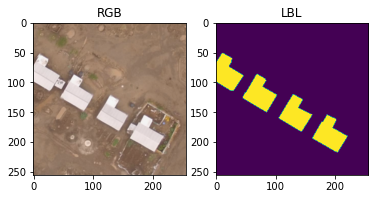

In [23]:
# plot a sample
test = BuildingDataset(TestIMG_ls, TestLBL_ls, transform = None)
test_pair = random.choice(test)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

### Vanilla Four layer U-Net Baseline

In [24]:
weights_4UNet = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_Four-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_057458.pth"))
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

7763041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 2.1856992304947198e-07, Maximum: 0.00715713482350111, Mean: 0.00047832250129431486, St dev: 0.0012262300588190556
True Positive = 7227, True Negative = 57078 False Negative = 14, False Positive = 1217
Precision = 0.8558740019798279, Recall = 0.9980665445327759, Specificity = 0.9791234135627747 Overall Accuracy = 0.9812164306640625, Intersection-over-Union = 0.8544573187828064, Dice-Score = 0.9215173721313477


Text(0.5, 1.0, 'Binary Segmentation')

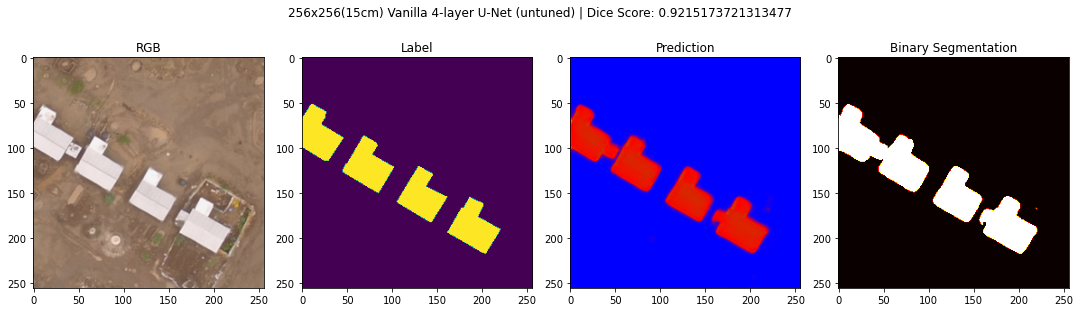

In [25]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = Four_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)
   
    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) Vanilla 4-layer U-Net (untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### Qubvel OpenCities EB1-UNet

In [26]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 2.6025144479112318e-15, Maximum: 0.9998736381530762, Mean: 0.0029381969943642616, St dev: 0.04984711483120918
True Positive = 489, True Negative = 58295 False Negative = 6752, False Positive = 0
Precision = 1.0, Recall = 0.06753210723400116, Specificity = 1.0 Overall Accuracy = 0.89697265625, Intersection-over-Union = 0.06753210723400116, Dice-Score = 0.1265200525522232


Text(0.5, 1.0, 'Binary Segmentation')

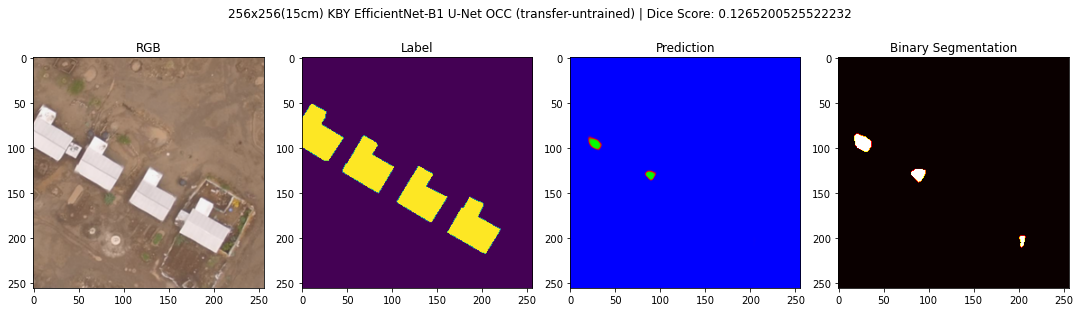

In [27]:
qubvelEB1_UNet.eval()

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)

    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet-B1 U-Net OCC (transfer-untrained) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet Vanilla (No ImageNet) Baseline

In [28]:
EB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

EB1_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY3969:462_256oc1_EB1-UNet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_027955.pth"))
EB1_weights = torch.load(EB1_weights, map_location = device)
EB1_UNet.load_state_dict(EB1_weights["Model:"])
EB1_UNet.to(device = device)

print(sum(p.numel() for p in EB1_UNet.parameters() if p.requires_grad == True))

FileNotFoundError: [Errno 2] No such file or directory: '/home/chris/Dropbox/HOTOSM/SAMPLE/best_weights/BASE_15cmKBY/KBY3969:462_256oc1_EB1-UNet-NoIMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRONPLATEAU(min1e-8)_iter_027955.pth'

In [ ]:
EB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))


# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet (NoIMN) Vanilla | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet ImageNet (trained-untuned) Baseline

In [29]:
EB1_UNet_IMN = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

IMN_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB1-Unet-IMN_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_064618.pth"))
IMN_weights = torch.load(IMN_weights, map_location = device)
EB1_UNet_IMN.load_state_dict(IMN_weights["Model:"])
EB1_UNet_IMN.to(device = device)

print(sum(p.numel() for p in EB1_UNet_IMN.parameters() if p.requires_grad == True))

7005041


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 1.921232950508056e-08, Maximum: 0.009192977100610733, Mean: 0.0004823884228244424, St dev: 0.0012368428288027644
True Positive = 7227, True Negative = 57126 False Negative = 14, False Positive = 1169
Precision = 0.8607670068740845, Recall = 0.9980665445327759, Specificity = 0.9799468517303467 Overall Accuracy = 0.9819488525390625, Intersection-over-Union = 0.8593341112136841, Dice-Score = 0.9243460297584534


Text(0.5, 1.0, 'Binary Segmentation')

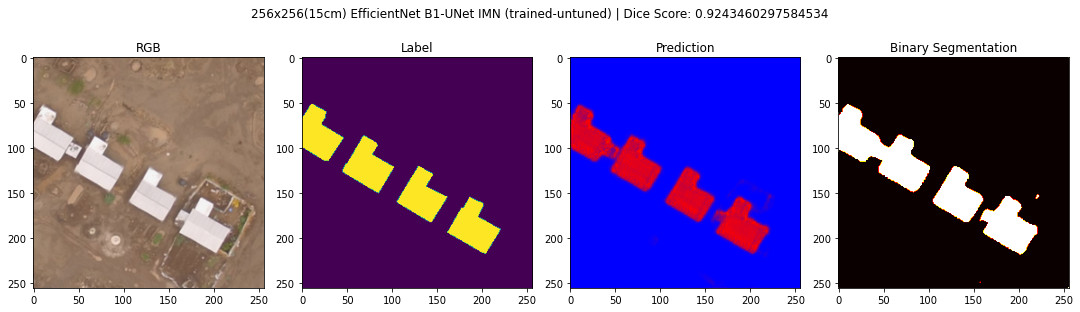

In [30]:
EB1_UNet_IMN.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_IMN(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) EfficientNet B1-UNet IMN (trained-untuned) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

### EfficientNet B1-UNet OCC (transfer-trained) Baseline

In [35]:
EB1_UNet_OCCtrans = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

OCCtrans_weights = os.path.abspath(os.path.join(data_path, "best_weights", "BASE_15cmKBY", "KBY5719:1224_256oc_EB1-Unet-qubvel_lr1e-3_wd1e-5_b16_ep500_BCE_RLRonPlateau(min1e-8)_iter_082697.pth"))
OCCtrans_weights = torch.load(OCCtrans_weights, map_location = device)
EB1_UNet_OCCtrans.load_state_dict(OCCtrans_weights["Model:"])
EB1_UNet_OCCtrans.to(device = device)

print(sum(p.numel() for p in EB1_UNet_OCCtrans.parameters() if p.requires_grad == True))

8757105


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
Minimum: 5.622140086813943e-09, Maximum: 0.007939225994050503, Mean: 0.0004866467497777194, St dev: 0.0012523201294243336
True Positive = 7233, True Negative = 57033 False Negative = 8, False Positive = 1262
Precision = 0.8514420390129089, Recall = 0.9988951683044434, Specificity = 0.9783514738082886 Overall Accuracy = 0.980621337890625, Intersection-over-Union = 0.8506409525871277, Dice-Score = 0.9192933440208435


Text(0.5, 1.0, 'Binary Segmentation')

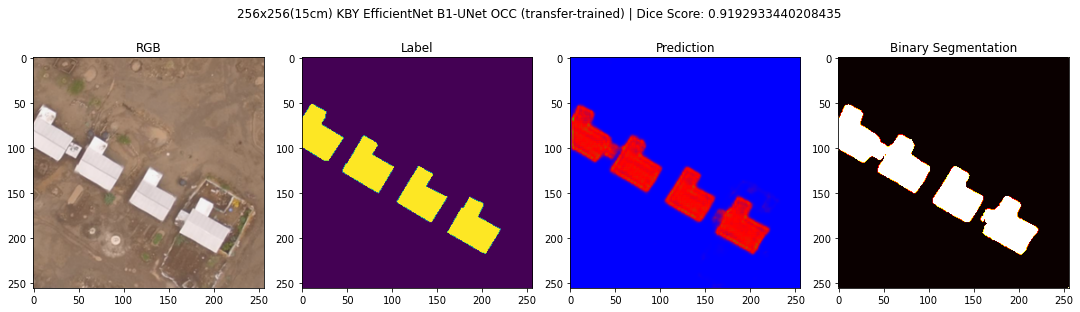

In [37]:
EB1_UNet_OCCtrans.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img = img.to(device = device)
lbl = lbl.to(device = device)
print(img.shape, lbl.shape)

with torch.no_grad():
    prediction = EB1_UNet_OCCtrans(img.unsqueeze(0))
    prediction = prediction.squeeze(0)
    
    print("Minimum: {0}, Maximum: {1}, Mean: {2}, St dev: {3}".format(prediction.min(), prediction.max(), prediction.mean(), prediction.std()))

    pred_BOOL = (prediction > 0.001).to(torch.float32)

    # Booleanise
    pred_BOOL = pred_BOOL.bool()
    lbl = lbl.bool()

    # 1st order statistics
    TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
    TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
    FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
    FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

    # 2nd order statistics
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
    Specificity = (TN / (FP + TN)) #True Negative Rate
    OA = ((TP + TN) / (TP + TN + FP + FN))
    IoU = (TP / (TP + FN + FP))
    Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

print("True Positive = {0}, True Negative = {1} False Negative = {2}, False Positive = {3}".format(TP, TN, FN, FP))
print("Precision = {0}, Recall = {1}, Specificity = {2} Overall Accuracy = {3}, Intersection-over-Union = {4}, Dice-Score = {5}".format(Precision, Recall, Specificity, OA, IoU, Dice))

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
fig.suptitle("256x256(15cm) KBY EfficientNet B1-UNet OCC (transfer-trained) | Dice Score: {0}".format(Dice))
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILlbl = lbl.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILlbl)
ax.set_title('Label')

ax = fig.add_subplot(1, 4, 3)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 4)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')

## Testing on new Namabasa_tif

In [11]:
torch.cuda.empty_cache()

In [12]:
from osgeo import gdal
from PIL import Image
import torchvision.transforms.functional as f

Namabasa_tif = gdal.Open(os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/3857_TEST_Namabasa.tif"))
Namabasa_arr = Namabasa_tif.ReadAsArray()
Namabasa_t = f.to_tensor(Namabasa_arr)
Namabasa_t = torch.transpose(Namabasa_t, 1, 0)

print(Namabasa_t.shape)

Namabasa_t = Namabasa_t.to(device = device)

Net = EB1_UNet_IMN.to(device = device)
Net.eval()

output = Net(Namabasa_t.unsqueeze(0))
output = output.squeeze(0)

PILout = output.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILout, cmap = "brg")
#plt.colorbar(boundaries = np.arange(0, 1.0, 0.1), ticks = np.arange(0, 1.0, 0.1),
#             orientation = "horizontal")
ax.set_title('Prediction')


print(output)

torch.Size([3, 6943, 6529])


RuntimeError: CUDA out of memory. Tried to allocate 1.35 GiB (GPU 0; 7.93 GiB total capacity; 4.91 GiB already allocated; 145.38 MiB free; 5.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF